# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

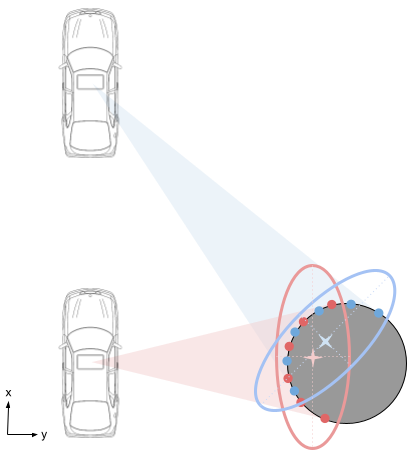

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample 25 points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

In [1]:
#setup - rememeber to switch to dnn kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


2.3.0


Autosaving every 180 seconds


In [2]:
#import training data
#toy data set
# d1 = np.loadtxt('training_data/scan1.txt')
# d2 = np.loadtxt('training_data/scan2.txt')
# gt = np.loadtxt('training_data/ground_truth.txt')

## slightly larger prism dataset
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k.txt")

#KITTI real world data
# d1 = np.loadtxt('training_data/ICET_KITTI_scan1.txt')
# d2 = np.loadtxt('training_data/ICET_KITTI_scan2.txt')
# gt = np.loadtxt('training_data/ICET_KITTI_ground_truth.txt')

d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1.txt")
d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2.txt")
gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth.txt")


# #combine two datasets
# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)

points_per_sample = 25 #100 #25 #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)
# print(tf.shape(scan1))
# print(tf.shape(gt))

#split data into training and validation sets
tsplit = 0.95 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

# x_train = tf.reshape(x_train, [-1, 50, 1, 1, 1])
print(tf.shape(x_train))
# x_train = tf.reshape(x_train, [-1, 50, 3])

# print(x_train[0,0,:])

tf.Tensor([94608    50     3], shape=(3,), dtype=int32)


In [6]:
#train network
from network import Net
# from network import permNet as Net
# from network import PointNet as Net
# from network import PCRnet as Net
np.random.seed(1337)

runLen = 100

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("KITTInetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 64, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [scheduler, cp, tensorboard_callback])
#add to callback to use stepped learning rate

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50, 3)]           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 50, 3)             12        
_________________________________________________________________
dense_30 (Dense)             (None, 50, 64)            256       
_________________________________________________________________
batch_normalization_37 (Batc (None, 50, 64)            256       
_________________________________________________________________
dense_31 (Dense)             (None, 50, 128)           8320      
_________________________________________________________________
batch_normalization_38 (Batc (None, 50, 128)           512       
_________________________________________________________________
dense_32 (Dense)             (None, 50, 256)          

INFO:tensorflow:Assets written to: KITTInetCP.kmod\assets
1183/1183 [==============================] - 39s 33ms/step - loss: 0.1591 - val_loss: 0.1194
Epoch 3/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.1479 - val_loss: 0.1601
Epoch 4/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.1463 - val_loss: 0.2341
Epoch 5/100
1182/1183 [============================>.] - ETA: 0s - loss: 0.1350WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000027185FFA0D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: KITTInetCP.kmod\assets
1183/1183 [==============================] - 39s 33ms/step - loss: 0.0995 - val_loss: 0.0759
Epoch 29/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.0996 - val_loss: 0.1373
Epoch 30/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.0975 - val_loss: 0.0937
Epoch 31/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.0990 - val_loss: 0.1219
Epoch 32/100
1181/1183 [============================>.] - ETA: 0s - loss: 0.0982WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x0000027155D88EE8> a

1183/1183 [==============================] - 35s 30ms/step - loss: 0.0828 - val_loss: 0.0628
Epoch 71/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.0833 - val_loss: 0.0687
Epoch 72/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.0813 - val_loss: 0.0624
Epoch 73/100
1182/1183 [============================>.] - ETA: 0s - loss: 0.0830WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x00000271899EB4C8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

<IPython.core.display.Javascript object>


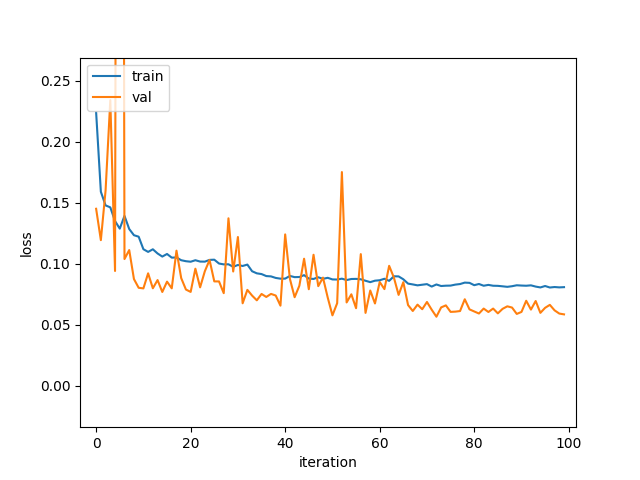

Text(0, 0.5, 'loss')

In [7]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [15]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test)
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test)

err = y_test - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




estimated translation x y z
[[-0.00183885 -1.530133   -0.01541665]
 [-0.3157668   0.02872196  0.0578463 ]
 [-0.8301854  -0.7107129   0.08665902]
 ...
 [-0.9372581  -1.6399627  -0.03817546]
 [ 0.10456914  0.9221011   0.12592587]
 [ 0.025706   -1.592695    0.09941949]]
actual translation x y z
tf.Tensor(
[[-0.05037675 -1.60406518 -0.01121312]
 [-0.37164852 -0.03565831  0.05817956]
 [-0.86829621 -0.8203817   0.10914572]
 ...
 [-1.00422812 -1.87648571 -0.03637484]
 [ 0.16516846  0.92283893  0.10383689]
 [ 0.04915697 -1.57752538  0.10983516]], shape=(4980, 3), dtype=float64)

 Error 
 tf.Tensor(
[[-0.0485379  -0.07393217  0.00420353]
 [-0.05588171 -0.06438027  0.00033326]
 [-0.03811079 -0.10966879  0.0224867 ]
 ...
 [-0.06696999 -0.23652303  0.00180062]
 [ 0.06059933  0.00073785 -0.02208898]
 [ 0.02345096  0.01516962  0.01041567]], shape=(4980, 3), dtype=float64)
tf.Tensor(-0.04398006325463044, shape=(), dtype=float64)


<IPython.core.display.Javascript object>


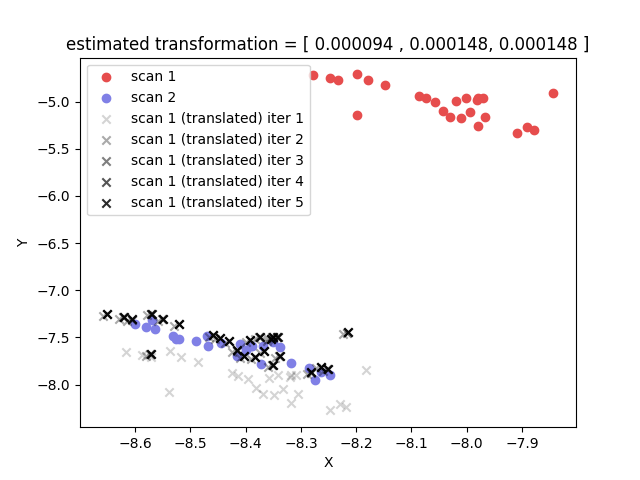

tf.Tensor([4980   50    3], shape=(3,), dtype=int32)


In [37]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = 127 #sample number (from x_test)
print(tf.shape(x_test))

c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')

# print(np.shape(x_test[n][None,:]))

inputs = x_test[n][None,:]
runlen = 5
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = 0.1*y_test[n] #show actual solution
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

In [10]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")

#load network
# model = tf.keras.models.load_model("Net.kmod")3
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: KITTInet.kmod\assets


In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0566 with my ___NET

### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

In [ ]:
8**3 